# report stats, monitor change

record properties of ``treedb.sqlite3``
loaded from [Glottolog](https://glottolog.org)
[master repo](https://github.com/glottolog/glottolog) commit
and monitor changes by diffing this

<div style="text-align: right">
  <a href="https://nbviewer.jupyter.org/github/glottolog/treedb/blob/master/Stats.ipynb">
      latest version from GitHub in nbviewer
  </a>
</div>

### contents
1. [clone/checkout](#clone/checkout)
2. [load](#load)
3. [treedb.sqlite3](#treedb.sqlite3)
4. [\_\_dataset\_\_](#__dataset__)
5. [\_\_producer\_\_](#__producer__)
6. [treedb.raw](#treedb.raw)
7. [languoid](#languoid)
8. [macroarea](#macroarea)
9. [country](#country)
10. [altname](#altname)
11. [source](#source)
12. [link](#link)
13. [endangerment](#endangerment)
14. [denormalized](#denormalized)

In [1]:
%matplotlib inline

import collections
import os

os.environ['SQLALCHEMY_WARN_20'] = 'true'

import pandas as pd
import sqlalchemy as sa
import matplotlib as mpl
import matplotlib.pyplot as plt

import treedb
import treedb.raw

treedb.configure_logging(log_sql=False)

treedb.__version__

'1.5.dev0'

## clone/checkout

In [2]:
%%time

TARGET = '../glottolog/'

TAG = 'v4.3-treedb-fixes'

treedb.checkout_or_clone(TAG, target=TARGET)

Wall time: 52.6 s


(CompletedProcess(args=['git', 'clone', '-c', 'advice.detachedHead=false', '--single-branch', '--branch', 'v4.3-treedb-fixes', '--depth', '1', 'https://github.com/glottolog/glottolog.git', WindowsPath('../glottolog')], returncode=0),
 CompletedProcess(args=['git', 'checkout', '-B', 'treedb', 'v4.3-treedb-fixes'], returncode=0))

## load

In [3]:
treedb.set_root(TARGET)

<treedb.proxies.PathProxy path='../glottolog/languoids/tree' inode=9007199254843767>

In [4]:
next(treedb.iterfiles())

(('abin1243',),
 <DirEntry 'md.ini'>,
 <treedb.files.ConfigParser at 0x28df24bc340>)

In [5]:
next(treedb.iterlanguoids())

(('abin1243',),
 {'id': 'abin1243',
  'parent_id': None,
  'level': 'language',
  'name': 'Abinomn',
  'hid': 'bsa',
  'iso639_3': 'bsa',
  'latitude': -2.92281,
  'longitude': 138.891,
  'macroareas': ['Papunesia'],
  'countries': [{'name': 'Indonesia', 'id': 'ID'}],
  'links': [{'url': 'http://endangeredlanguages.com/lang/1763',
    'title': 'Abinomn',
    'scheme': 'http'},
   {'url': 'https://www.wikidata.org/entity/Q56648',
    'title': None,
    'scheme': 'https'},
   {'url': 'https://en.wikipedia.org/wiki/Abinomn_language',
    'title': None,
    'scheme': 'https'}],
  'sources': {'glottolog': [{'bibfile': 'hh',
     'bibkey': 'e:Lagerberg:Moegip',
     'pages': None,
     'trigger': None},
    {'bibfile': 'hh',
     'bibkey': 'h:SilzerClouse:Index',
     'pages': None,
     'trigger': None},
    {'bibfile': 'hh',
     'bibkey': 'h:SilzerHeikkinen:Irian',
     'pages': None,
     'trigger': None},
    {'bibfile': 'hh',
     'bibkey': 'hv:Foley:Northwest-New-Guinea',
     'pages'

In [6]:
treedb.set_engine('treedb.sqlite3')

<treedb.proxies.SQLiteEngineProxy filename='treedb.sqlite3' size=None>

In [7]:
%%time

engine = treedb.load(rebuild=False, exclude_raw=False)
engine

0:02:06.666797
Wall time: 2min 6s


<treedb.proxies.SQLiteEngineProxy filename='treedb.sqlite3' size=69345280>

In [8]:
engine.file_mtime()

datetime.datetime(2021, 3, 17, 11, 47, 38, 568295)

In [9]:
engine.file_size(as_megabytes=True)

66.1328125

In [10]:
%time engine.file_sha256()

Wall time: 55 ms


'5ae1d8f37c2936c1902eca9ab288b77967671cc58ce9d5fcb0afad6d0b481145'

In [11]:
%time treedb.raw.checksum()

Wall time: 104 ms


'strong:sha256:db13f74ed52884084ab38b9693d42a589ff4ebc033ef1ed62b6463f44ea9320b'

In [12]:
%time treedb.raw.checksum(weak=True)

Wall time: 2.88 s


'weak:sha256:1f48d9a546fb99cab53eb171806d6a16c5d9affc9c6f49d615692fdbd636c58c'

In [13]:
%time treedb.check()

valid_glottocodeCheck: OK
valid_iso639_3Check: OK
valid_hidCheck: OK
clean_nameCheck: OK
family_parentCheck: OK
language_parentCheck: OK
dialect_parentCheck: OK
family_childrenCheck: OK
family_languagesCheck: OK
bookkeeping_no_childrenCheck: OK
no_empty_filesCheck: OK
Wall time: 912 ms


True

In [14]:
%time treedb.checksum()

Wall time: 4.69 s


'path_json:id:sha256:c384ab4887ec10a4f80baa1c36198a94f127c46aee768d3680ce3b474d0eac4e'

In [15]:
%time treedb.checksum(source='raw')

Wall time: 5.36 s


'path_json:id:sha256:64c5f81116552da534f6e71baa7e428b2575ab0bc8237788353132d9c1bb2883'

## treedb.sqlite3

In [16]:
treedb.configure_logging(level='INFO', log_sql=True)

treedb.scalar(sa.select(sa.func.sqlite_version()))

[INFO@treedb.logging_] treedb version: 1.5.dev0
SELECT sqlite_version() AS sqlite_version_1
[generated in 0.00052s] ()


'3.35.0'

In [17]:
application_id = treedb.scalar(sa.text('PRAGMA application_id'))

assert application_id == 1122 == 0x462
assert application_id == sum(ord(c) for c in treedb.Dataset.__tablename__)
assert treedb.Dataset.__tablename__ == '__dataset__'

application_id

PRAGMA application_id
[generated in 0.00047s] ()


1122

In [18]:
from treedb import pd_read_sql as read_sql

read_sql(treedb.select_tables_nrows(), index_col='table_name')

SELECT sqlite_master.name 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name NOT LIKE ? ORDER BY sqlite_master.name
[generated in 0.00040s] ('table', 'sqlite_%')
[INFO@treedb.shortcuts] pandas version: 1.2.3
SELECT ? AS table_name, (SELECT count(*) AS n 
FROM __dataset__) AS n_rows UNION ALL SELECT ? AS table_name, (SELECT count(*) AS n 
FROM __producer__) AS n_rows UNION ALL SELECT ? AS table_name, (SELECT count(*) AS n 
FROM _file) AS n_rows UNION ALL SELECT ? AS table_name, (SELECT count(*) AS n 
FROM _option) AS n_rows UNION ALL SELECT ? AS table_name, (SELECT count(*) AS n 
FROM _value) AS n_rows UNION ALL SELECT ? AS table_name, (SELECT count(*) AS n 
FROM altname) AS n_rows UNION ALL SELECT ? AS table_name, (SELECT count(*) AS n 
FROM altnameprovider) AS n_rows UNION ALL SELECT ? AS table_name, (SELECT count(*) AS n 
FROM bibfile) AS n_rows UNION ALL SELECT ? AS table_name, (SELECT count(*) AS n 
FROM bibitem) AS n_rows UNION ALL SELECT ? AS table_name, (SE

,n_rows
table_name,
__dataset__,1
__producer__,1
_file,25439
_option,53
_value,603642
altname,150561
altnameprovider,11
bibfile,38
bibitem,143806


In [19]:
treedb.print_rows(treedb.sqlite_master.select_views(), format_='{name}')

SELECT sqlite_master.name 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name NOT LIKE ? ORDER BY sqlite_master.name
[cached since 0.04916s ago] ('view', 'sqlite_%')


example
path_json
stats


In [20]:
from treedb import print_table_sql as print_sql

print_sql('sqlite_master')

SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
[generated in 0.00056s] ('table', 'sqlite_master')
SELECT count(*) AS n_rows 
FROM sqlite_master
[generated in 0.00046s] ()


None
56


## \_\_dataset\_\_

In [21]:
from treedb import Dataset

print_sql(Dataset)

SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
[cached since 0.01009s ago] ('table', '__dataset__')
SELECT count(*) AS n_rows 
FROM __dataset__
[generated in 0.00034s] ()


CREATE TABLE __dataset__ (
	id INTEGER NOT NULL CHECK (id = 1), 
	title TEXT NOT NULL CHECK (title != ''), 
	git_commit VARCHAR(40) NOT NULL CHECK (length(git_commit) = 40), 
	git_describe TEXT NOT NULL CHECK (git_describe != ''), 
	clean BOOLEAN NOT NULL, 
	exclude_raw BOOLEAN NOT NULL, 
	PRIMARY KEY (id), 
	UNIQUE (git_commit), 
	UNIQUE (git_describe), 
	CHECK (clean IN (0, 1)), 
	CHECK (exclude_raw IN (0, 1))
)
1


In [22]:
dataset, = treedb.iterrows(sa.select(Dataset), mappings=True)

pd.DataFrame.from_dict(dataset, orient='index', columns=['__dataset__'])

SELECT __dataset__.id, __dataset__.title, __dataset__.git_commit, __dataset__.git_describe, __dataset__.clean, __dataset__.exclude_raw 
FROM __dataset__
[generated in 0.00041s] ()


,__dataset__
id,1
title,Glottolog treedb
git_commit,11a2332ca32fa525c7b757287cd09c2e361a5011
git_describe,v4.3-treedb-fixes
clean,True
exclude_raw,False


## \_\_producer\_\_

In [23]:
from treedb import Producer

print_sql(Producer)

SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
[cached since 0.02987s ago] ('table', '__producer__')
SELECT count(*) AS n_rows 
FROM __producer__
[generated in 0.00031s] ()


CREATE TABLE __producer__ (
	id INTEGER NOT NULL CHECK (id = 1), 
	name TEXT NOT NULL CHECK (name != ''), 
	version TEXT NOT NULL CHECK (version != ''), 
	PRIMARY KEY (id), 
	UNIQUE (name)
)
1


In [24]:
producer, = treedb.iterrows(sa.select(Producer), mappings=True)

pd.DataFrame.from_dict(producer, orient='index', columns=['__producer__'])

SELECT __producer__.id, __producer__.name, __producer__.version 
FROM __producer__
[generated in 0.00043s] ()


,__producer__
id,1
name,treedb
version,1.5.dev0


## `treedb.raw`

In [25]:
from treedb.raw import File, Option, Value

for model in (File, Option, Value):
    print_sql(model)

SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
[cached since 0.04956s ago] ('table', '_file')
SELECT count(*) AS n_rows 
FROM _file
[generated in 0.00053s] ()


CREATE TABLE _file (
	id INTEGER NOT NULL, 
	glottocode VARCHAR(8) NOT NULL CHECK (length(glottocode) = 8), 
	path TEXT NOT NULL CHECK (length(path) >= 8 AND (length(path) + 1) % 9 = 0), 
	size INTEGER NOT NULL CHECK (size > 0), 
	sha256 VARCHAR(64) NOT NULL CHECK (length(sha256) = 64), 
	PRIMARY KEY (id), 
	CHECK (substr(path, -length(glottocode)) = glottocode), 
	UNIQUE (glottocode), 
	UNIQUE (path), 
	UNIQUE (sha256)
)
25439


SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
[cached since 0.0561s ago] ('table', '_option')
SELECT count(*) AS n_rows 
FROM _option
[generated in 0.00041s] ()


CREATE TABLE _option (
	id INTEGER NOT NULL, 
	section TEXT NOT NULL CHECK (section != ''), 
	option TEXT NOT NULL CHECK (option != ''), 
	is_lines BOOLEAN, 
	PRIMARY KEY (id), 
	UNIQUE (section, option), 
	CHECK (is_lines IN (0, 1))
)
53


SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
[cached since 0.06132s ago] ('table', '_value')
SELECT count(*) AS n_rows 
FROM _value
[generated in 0.00045s] ()


CREATE TABLE _value (
	file_id INTEGER NOT NULL, 
	option_id INTEGER NOT NULL, 
	line INTEGER NOT NULL CHECK (line > 0), 
	value TEXT NOT NULL CHECK (value != ''), 
	PRIMARY KEY (file_id, option_id, line), 
	UNIQUE (file_id, line), 
	FOREIGN KEY(file_id) REFERENCES _file (id), 
	FOREIGN KEY(option_id) REFERENCES _option (id)
) WITHOUT ROWID
603642


In [26]:
read_sql(sa.select(File).limit(5), index_col='id')

SELECT _file.id, _file.glottocode, _file.path, _file.size, _file.sha256 
FROM _file
 LIMIT ? OFFSET ?
[generated in 0.00057s] (5, 0)


,glottocode,path,size,sha256
id,,,,
1,abin1243,abin1243,1229,b7c19c6bc411908419022568fa021e39d64b1e9ab2e57c...
2,abis1238,abis1238,1708,b0d8c9aca4d8dcca721e8dac7ff33c4f51f116ad300f35...
3,abkh1242,abkh1242,306,5dd28ae1265a0967b1a236d06c7fd6e7ac3b9e32d866dd...
4,abkh1243,abkh1242/abkh1243,257,a5900355c69af22d94eaa0a147b95fc291270634bc033c...
5,abaz1241,abkh1242/abkh1243/abaz1241,2420,b0e42d67befef9ae9e12a5e34ac65b3325ff2ffd774dba...


In [27]:
read_sql(sa.select(Option).limit(5), index_col='id')

SELECT _option.id, _option.section, _option.option, _option.is_lines 
FROM _option
 LIMIT ? OFFSET ?
[generated in 0.00068s] (5, 0)


,section,option,is_lines
id,,,
1,core,name,False
2,core,hid,False
3,core,level,False
4,core,iso639-3,False
5,core,latitude,False


In [28]:
read_sql(sa.select(Value).limit(5), index_col=['file_id', 'option_id'])

SELECT _value.file_id, _value.option_id, _value.line, _value.value 
FROM _value
 LIMIT ? OFFSET ?
[generated in 0.00045s] (5, 0)


line     value
file_id option_id                
1       1             1   Abinomn
        2             2       bsa
        3             3  language
        4             4       bsa
        5             5  -2.92281

In [29]:
select_file_values = sa.select(Option.section, Option.option, Value.line, Value.value)\
                     .select_from(sa.join(File, Value).join(Option))\
                     .where(File.glottocode == sa.bindparam('glottocode'))

read_sql(select_file_values, params={'glottocode': 'abin1243'},
         index_col=['section', 'option', 'line'])

SELECT _option.section, _option.option, _value.line, _value.value 
FROM _file JOIN _value ON _file.id = _value.file_id JOIN _option ON _option.id = _value.option_id 
WHERE _file.glottocode = ?
[generated in 0.00058s] ('abin1243',)


value
section        option              line                                                   
core           name                1                                               Abinomn
               hid                 2                                                   bsa
               level               3                                              language
               iso639-3            4                                                   bsa
               latitude            5                                              -2.92281
               longitude           6                                               138.891
               macroareas          7                                             Papunesia
               countries           8                                        Indonesia (ID)
               links               9     [Abinomn](http://endangeredlanguages.com/lang/...
                                   10               https://www.wikidata.org/entity/Q56648
                                   11       https://en.wikipedia.org/wiki/Abinomn_language
sources        glottolog           12                            **hh:e:Lagerberg:Moegip**
                                   13                          **hh:h:SilzerClouse:Index**
                                   14                       **hh:h:SilzerHeikkinen:Irian**
                                   15                 **hh:hv:Foley:Northwest-New-Guinea**
                                   16               **hh:hvtyp:DonohueMusgrave:Melanesia**
                                   17                               **hh:w:Fiwei:Abinomn**
altnames       multitree           18                                               "Baso"
                                   19                                              Abinomn
                                   20                                             Avinomen
                                   21                                                 Foja
                                   22                                                 Foya
               lexvo               23                                         Abinomn [en]
                                   24                                Abinomn language [en]
                                   25                                       Abinomneg [br]
                                   26                                  Lingua abinomn [gl]
                                   27                                Llingua Abinomn [ast]
               hhbib_lgcode        28                                                 Baso
               elcat               29                                               "Baso"
                                   30                                              Abinomn
                                   31                                             Avinomen
                                   32                                                 Foja
                                   33                                                 Foya
triggers       lgcode              34                                         macrohistory
                                   35                                               moegip
identifier     multitree           36                                                  bsa
               endangeredlanguages 37                                                 1763
classification familyrefs          38                          **hh:h:SilzerClouse:Index**
                                   39               **hh:hvtyp:DonohueMusgrave:Melanesia**
endangerment   status              40                                             shifting
               source              41                                                ElCat
               date                42                                  2017-08-19T08:16:16
               comment             43    Abinomn (1763-bsa) = Endangered (20 perc

SELECT (length(_file.path) + ?) / ? AS path_depth, languoid.level, count(*) AS n_files 
FROM _file JOIN languoid ON _file.glottocode = languoid.id GROUP BY (length(_file.path) + ?) / ?, languoid.level ORDER BY path_depth, languoid.level
[generated in 0.00051s] (1, 9, 1, 9)
[INFO@numexpr.utils] Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[INFO@numexpr.utils] NumExpr defaulting to 8 threads.


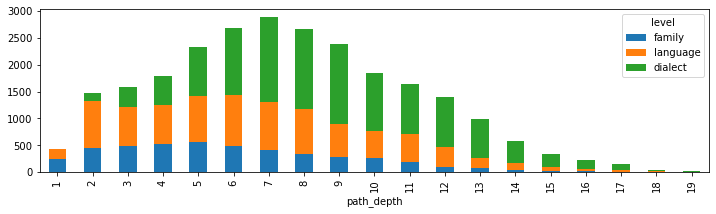

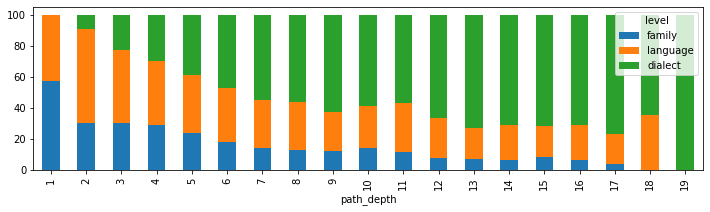

In [30]:
path_depth = File.path_depth()

select_path_depths = sa.select(path_depth,
                               treedb.Languoid.level, sa.func.count().label('n_files'))\
                     .select_from(sa.join(File, treedb.Languoid,
                                          File.glottocode == treedb.Languoid.id))\
                     .group_by(path_depth, treedb.Languoid.level)\
                     .order_by('path_depth', 'level')

_ = read_sql(select_path_depths, index_col=['path_depth', 'level'])\
    .unstack(fill_value=0).droplevel(0, axis='columns')[list(treedb.LEVEL)]

_.plot.bar(stacked=True, figsize=(12, 3))

(100 * _.div(_.sum(axis='columns'), axis='rows')).plot.bar(stacked=True, figsize=(12, 3));

SELECT _file.size AS file_size, count(*) AS n_files 
FROM _file GROUP BY _file.size ORDER BY file_size
[generated in 0.00055s] ()


,count,min,max
file_size,3229.0,65.0,46117.0


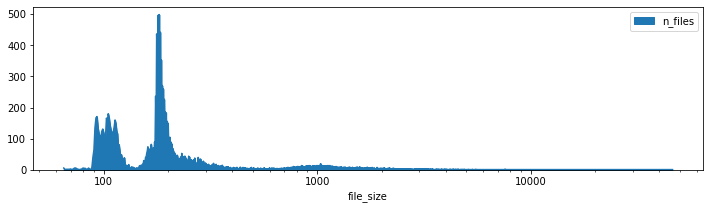

In [31]:
file_size = File.size.label('file_size')

select_file_sizes = sa.select(file_size, sa.func.count().label('n_files'))\
                    .group_by(file_size)\
                    .order_by('file_size')

_ = read_sql(select_file_sizes, index_col='file_size')

_.plot.area(figsize=(12, 3), logx=True).xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
_.index.to_series().describe().to_frame().transpose()[['count', 'min', 'max']]

SELECT file_nvalues.n_values, count(*) AS n_files 
FROM (SELECT _file.glottocode AS glottocode, count(DISTINCT _value.option_id) AS n_values 
FROM _file JOIN _value ON _file.id = _value.file_id GROUP BY _file.glottocode) AS file_nvalues GROUP BY file_nvalues.n_values ORDER BY file_nvalues.n_values
[generated in 0.00054s] ()


,count,min,max
n_values,35.0,2.0,36.0


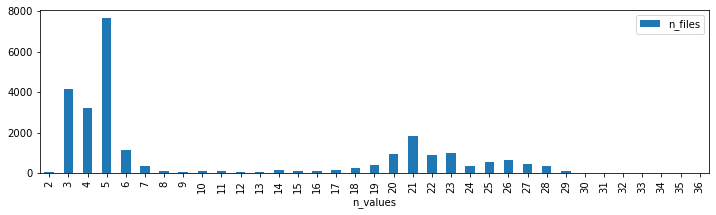

In [32]:
file_nvalues = sa.select(File.glottocode,
                         sa.func.count(Value.option_id.distinct()).label('n_values'))\
               .select_from(sa.join(File, Value))\
               .group_by(File.glottocode)\
               .alias('file_nvalues')\
               .c.n_values

select_nvalues = sa.select(file_nvalues, sa.func.count().label('n_files'))\
                 .group_by(file_nvalues)\
                 .order_by(file_nvalues)

_ = read_sql(select_nvalues, index_col='n_values')

_.plot.bar(figsize=(12, 3))
_.index.to_series().describe().to_frame().transpose()[['count', 'min', 'max']]

SELECT length(_value.value) AS value_length, count(*) AS n_values 
FROM _value GROUP BY length(_value.value) ORDER BY value_length
[generated in 0.00056s] ()


,count,min,max
value_length,635.0,1.0,6215.0


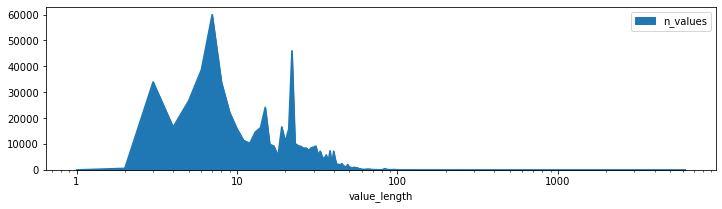

In [33]:
value_length = sa.func.length(Value.value).label('value_length')

select_value_length = sa.select(value_length, sa.func.count().label('n_values'))\
                      .group_by(value_length)\
                      .order_by('value_length')

_ = read_sql(select_value_length, index_col='value_length')

_.plot.area(figsize=(12, 3), logx=True).xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
_.index.to_series().describe().to_frame().transpose()[['count', 'min', 'max']]

In [34]:
%time treedb.raw.print_stats()

[INFO@treedb.raw.values] fetch statistics
SELECT _option.section, _option.option, count(*) AS n 
FROM _option JOIN _value ON _option.id = _value.option_id GROUP BY _option.section, _option.option ORDER BY _option.section, n DESC
[generated in 0.00053s] ()


altnames               multitree              54,586
altnames               hhbib_lgcode           30,033
altnames               lexvo                  26,027
altnames               elcat                  23,390
altnames               aiatsis                6,542
altnames               wals                   2,441
altnames               wals other             2,097
altnames               moseley & asher (1994) 2,089
altnames               ruhlen (1987)          2,007
altnames               glottolog              1,346
altnames               ethnologue             3
classification         subrefs                15,744
classification         sub                    11,633
classification         familyrefs             706
classification         family                 208
core                   links                  29,297
core                   name                   25,439
core                   level                  25,439
core                   macroareas             20,878
core      

## languoid

In [35]:
from treedb import LEVEL, Languoid

FAMILY, LANGUAGE, DIALECT = LEVEL

print_sql(Languoid)

SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
[cached since 2.457s ago] ('table', 'languoid')
SELECT count(*) AS n_rows 
FROM languoid
[generated in 0.00051s] ()


CREATE TABLE languoid (
	id VARCHAR(8) NOT NULL CHECK (length(id) = 8), 
	name VARCHAR NOT NULL CHECK (name != ''), 
	level VARCHAR(8) NOT NULL, 
	parent_id VARCHAR(8), 
	hid TEXT CHECK (length(hid) >= 3), 
	iso639_3 VARCHAR(3) CHECK (length(iso639_3) = 3), 
	latitude FLOAT CHECK (latitude BETWEEN -90 AND 90), 
	longitude FLOAT CHECK (longitude BETWEEN -180 AND 180), 
	PRIMARY KEY (id), 
	CHECK ((latitude IS NULL) = (longitude IS NULL)), 
	UNIQUE (name), 
	CHECK (level IN ('family', 'language', 'dialect')), 
	FOREIGN KEY(parent_id) REFERENCES languoid (id) DEFERRABLE INITIALLY DEFERRED, 
	UNIQUE (hid), 
	UNIQUE (iso639_3)
) WITHOUT ROWID
25439


In [36]:
%time treedb.print_languoid_stats()

WITH RECURSIVE tree(parent_id, child_id) AS 
(SELECT root.id AS parent_id, root.id AS child_id 
FROM languoid AS root 
WHERE root.parent_id IS NULL UNION ALL SELECT tree.parent_id AS parent_id, child.id AS child_id 
FROM tree JOIN languoid AS child ON tree.child_id = child.parent_id)
 SELECT ? AS kind, count(*) AS n 
FROM languoid UNION ALL SELECT ? AS kind, count(*) AS n 
FROM languoid 
WHERE languoid.level = ? AND languoid.parent_id IS NULL UNION ALL SELECT ? AS kind, count(*) AS n 
FROM languoid 
WHERE languoid.level = ? AND languoid.parent_id IS NULL UNION ALL SELECT ? AS kind, count(*) AS n 
FROM languoid 
WHERE languoid.parent_id IS NULL UNION ALL SELECT ? AS kind, count(*) AS n 
FROM languoid 
WHERE languoid.level = ? UNION ALL SELECT ? AS kind, count(*) AS n 
FROM languoid 
WHERE languoid.level = ? AND languoid.parent_id IS NOT NULL UNION ALL SELECT ? AS kind, count(*) AS n 
FROM languoid 
WHERE languoid.level = ? UNION ALL SELECT ? AS kind, count(*) AS n 
FROM tree JOIN languo

25,439 languoids
   244 families
   181 isolates
   425 roots
 8,516 languages
 4,265 subfamilies
12,414 dialects
 7,606 Spoken L1 Languages
   196 Sign Language
   123 Unclassifiable
    81 Pidgin
    67 Unattested
    29 Artificial Language
    12 Mixed Language
    10 Speech Register
 8,124 All
   392 Bookkeeping
Wall time: 364 ms


In [37]:
read_sql(sa.select(Languoid).limit(5), index_col='id')

SELECT languoid.id, languoid.name, languoid.level, languoid.parent_id, languoid.hid, languoid.iso639_3, languoid.latitude, languoid.longitude 
FROM languoid
 LIMIT ? OFFSET ?
[generated in 0.00052s] (5, 0)


,name,level,parent_id,hid,iso639_3,latitude,longitude
id,,,,,,,
3adt1234,3Ad-Tekles,dialect,nort3292,None,None,NaN,NaN
aala1237,Aalawa,dialect,ramo1244,None,None,NaN,NaN
aant1238,Aantantara,dialect,nort2920,None,None,NaN,NaN
aari1238,Aari-Gayil,family,ahkk1235,aiz,aiz,NaN,NaN
aari1239,Aari,language,aari1238,aiw,aiw,5.95034,36.5721


In [38]:
read_sql(sa.select(Languoid).order_by('id').limit(5), index_col='id')

SELECT languoid.id, languoid.name, languoid.level, languoid.parent_id, languoid.hid, languoid.iso639_3, languoid.latitude, languoid.longitude 
FROM languoid ORDER BY languoid.id
 LIMIT ? OFFSET ?
[generated in 0.00047s] (5, 0)


,name,level,parent_id,hid,iso639_3,latitude,longitude
id,,,,,,,
3adt1234,3Ad-Tekles,dialect,nort3292,None,None,NaN,NaN
aala1237,Aalawa,dialect,ramo1244,None,None,NaN,NaN
aant1238,Aantantara,dialect,nort2920,None,None,NaN,NaN
aari1238,Aari-Gayil,family,ahkk1235,aiz,aiz,NaN,NaN
aari1239,Aari,language,aari1238,aiw,aiw,5.95034,36.5721


In [39]:
read_sql(sa.select(Languoid).order_by('name').limit(5), index_col='id')

SELECT languoid.id, languoid.name, languoid.level, languoid.parent_id, languoid.hid, languoid.iso639_3, languoid.latitude, languoid.longitude 
FROM languoid ORDER BY languoid.name
 LIMIT ? OFFSET ?
[generated in 0.00065s] (5, 0)


,name,level,parent_id,hid,iso639_3,latitude,longitude
id,,,,,,,
gane1238,!Gã!ne,language,east2867,NOCODE_Gane,None,-31.32,28.75
oung1238,!O!ung,language,book1242,oun,oun,-15.30,14.35
kwii1241,!Ui,family,tuuu1241,None,None,NaN,NaN
abda1238,'Abd Al-Kuri,dialect,soqo1240,None,None,NaN,NaN
aden1242,'Aden,dialect,jude1267,None,None,NaN,NaN


In [40]:
Child, Parent = (sa.orm.aliased(Languoid, name=n) for n in ('child', 'parent'))

select_parent_levels = sa.select(Child.level.label('child_level'),
                                 Parent.level.label('parent_level'),
                                 sa.func.count().label('n_languoids'))\
                       .select_from(sa.outerjoin(Child, Parent,
                                                 Child.parent_id == Parent.id))\
                       .group_by(Child.level, Parent.level)\
                       .order_by('child_level', 'parent_level')

read_sql(select_parent_levels, index_col=['child_level', 'parent_level'])\
    .unstack(fill_value=0).assign(all=lambda x: x.sum(axis='columns'))\
    .pipe(lambda x: x.append(x.sum().rename('all')))

SELECT child.level AS child_level, parent.level AS parent_level, count(*) AS n_languoids 
FROM languoid AS child LEFT OUTER JOIN languoid AS parent ON child.parent_id = parent.id GROUP BY child.level, parent.level ORDER BY child_level, parent_level
[generated in 0.00062s] ()


n_languoids                            all
parent_level         NaN dialect family language       
child_level                                            
dialect                0    1888      0    10526  12414
family               244       0   4265        0   4509
language             181       0   8335        0   8516
all                  425    1888  12600    10526  25439

In [41]:
select_lang_nisos = sa.select(Languoid.level.label('level'),
                              sa.func.count().label('n_languoids'),
                              sa.func.count(Languoid.iso639_3).label('n_isos'))\
                   .group_by(Languoid.level)\
                   .order_by('level')

read_sql(select_lang_nisos, index_col='level')\
    .assign(ratio=lambda x: 100 * x['n_isos'] / x['n_languoids'])

SELECT languoid.level AS level, count(*) AS n_languoids, count(languoid.iso639_3) AS n_isos 
FROM languoid GROUP BY languoid.level ORDER BY level
[generated in 0.00040s] ()


,n_languoids,n_isos,ratio
level,,,
dialect,12414,183,1.474142
family,4509,45,0.998004
language,8516,7804,91.639267


In [42]:
select_lang_nlocations = sa.select(Languoid.level.label('level'),
                                   sa.func.count().label('n_languoids'),
                                   sa.func.count(Languoid.latitude).label('n_locations'))\
                         .group_by(Languoid.level)\
                         .order_by('level')

read_sql(select_lang_nlocations, index_col='level')\
    .assign(ratio=lambda x: 100 * x['n_locations'] / x['n_languoids'])

SELECT languoid.level AS level, count(*) AS n_languoids, count(languoid.latitude) AS n_locations 
FROM languoid GROUP BY languoid.level ORDER BY level
[generated in 0.00055s] ()


,n_languoids,n_locations,ratio
level,,,
dialect,12414,275,2.215241
family,4509,17,0.377024
language,8516,8145,95.643495


SELECT languoid.latitude, languoid.longitude 
FROM languoid 
WHERE languoid.level = ?
[generated in 0.00063s] ('language',)


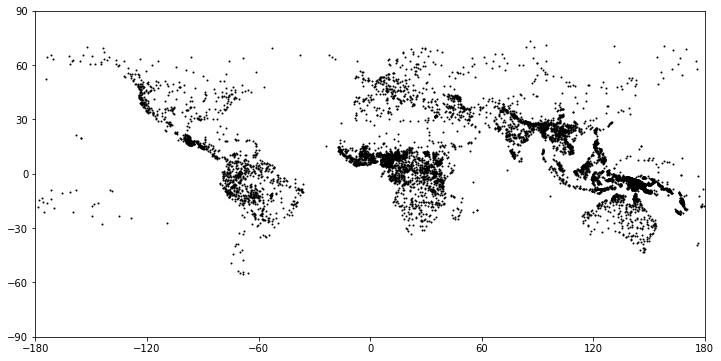

In [43]:
select_latlon = sa.select(Languoid.latitude, Languoid.longitude)\
                .where(Languoid.level == LANGUAGE)

latitudes, longitudes = zip(*treedb.iterrows(select_latlon))
    
plt.figure(figsize=(12, 6))
plt.axis([-180, 180, -90, 90])
plt.xticks(range(-180, 181, 60))
plt.yticks(range(-90, 91, 30))
plt.scatter(longitudes, latitudes, 1, 'black');

WITH RECURSIVE tree(parent_id, child_id) AS 
(SELECT root.id AS parent_id, child.id AS child_id 
FROM languoid AS root LEFT OUTER JOIN languoid AS child ON root.id = child.parent_id 
WHERE root.parent_id IS NULL AND root.level = ? UNION ALL SELECT tree.parent_id AS parent_id, child.id AS child_id 
FROM tree JOIN languoid AS child ON tree.child_id = child.parent_id)
 SELECT root.id AS family_id, count(child.id) AS n_languages 
FROM tree JOIN languoid AS root ON tree.parent_id = root.id LEFT OUTER JOIN languoid AS child ON tree.child_id = child.id 
WHERE child.level = ? GROUP BY root.id 
HAVING count(child.id) >= ? ORDER BY n_languages
[generated in 0.00060s] ('family', 'language', 100)


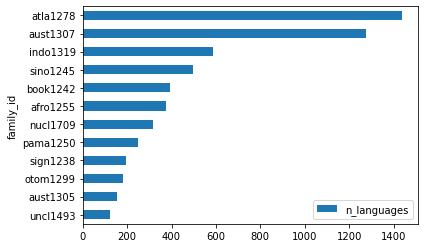

In [44]:
Family, Child, family_child = treedb.Languoid.parent_descendant(parent_root=True,
                                                                parent_level=FAMILY)

n_languages = sa.func.count(Child.id).label('n_languages')

select_family_nlanguages = sa.select(Family.id.label('family_id'), n_languages)\
                           .select_from(family_child)\
                           .where(Child.level == LANGUAGE)\
                           .group_by(Family.id)

select_top_families = select_family_nlanguages\
                      .having(n_languages >= 100)\
                      .order_by('n_languages')

read_sql(select_top_families, index_col='family_id').plot.barh();

WITH RECURSIVE tree(parent_id, child_id) AS 
(SELECT root.id AS parent_id, child.id AS child_id 
FROM languoid AS root LEFT OUTER JOIN languoid AS child ON root.id = child.parent_id 
WHERE root.parent_id IS NULL AND root.level = ? UNION ALL SELECT tree.parent_id AS parent_id, child.id AS child_id 
FROM tree JOIN languoid AS child ON tree.child_id = child.parent_id)
 SELECT family_nlanguages.n_languages AS family_size, count(*) AS n_families 
FROM (SELECT root.id AS family_id, count(child.id) AS n_languages 
FROM tree JOIN languoid AS root ON tree.parent_id = root.id LEFT OUTER JOIN languoid AS child ON tree.child_id = child.id 
WHERE child.level = ? GROUP BY root.id) AS family_nlanguages GROUP BY family_nlanguages.n_languages ORDER BY family_size
[generated in 0.00047s] ('family', 'language')


,count,min,max
family_size,56.0,2.0,1436.0


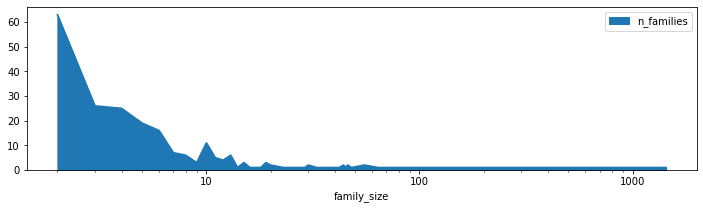

In [45]:
family_size = select_family_nlanguages\
              .alias('family_nlanguages')\
              .c.n_languages.label('family_size')

select_family_sizes = sa.select(family_size, sa.func.count().label('n_families'))\
                      .group_by(family_size)\
                      .order_by('family_size')

_ = read_sql(select_family_sizes, index_col='family_size')

_.plot.area(figsize=(12, 3), logx=True).xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
_.index.to_series().describe().to_frame().transpose()[['count', 'min', 'max']]

In [46]:
levels = sa.union_all(*[sa.select(sa.literal(l).label('level')) for l in LEVEL])\
         .cte(name='levels')

select_parent_nchildren = sa.select(Parent.id.label('parent_id'),
                                    Parent.level.label('parent_level'),
                                    levels.c.level.label('child_level'),
                                    sa.func.count(Child.id).label('n_children'))\
                          .select_from(sa.join(Parent, levels, sa.true())
                                       .outerjoin(Child, sa.and_(Parent.id == Child.parent_id, 
                                                                 Child.level == levels.c.level)))\
                          .group_by(Parent.id, Parent.level, levels.c.level)

read_sql(select_parent_nchildren)\
    .pivot_table(index='parent_level', columns='child_level', values='n_children',
                 aggfunc=['sum', 'max', 'mean'], fill_value=0)

WITH levels AS 
(SELECT ? AS level UNION ALL SELECT ? AS level UNION ALL SELECT ? AS level)
 SELECT parent.id AS parent_id, parent.level AS parent_level, levels.level AS child_level, count(child.id) AS n_children 
FROM languoid AS parent JOIN levels ON 1 = 1 LEFT OUTER JOIN languoid AS child ON parent.id = child.parent_id AND child.level = levels.level GROUP BY parent.id, parent.level, levels.level
[generated in 0.00057s] ('family', 'language', 'dialect')


sum                     max                      mean  \
child_level  dialect family language dialect family language   dialect   
parent_level                                                             
dialect         1888      0        0      22      0        0  0.152086   
family             0   4265     8335       0     45      392  0.000000   
language       10526      0        0      32      0        0  1.236026   

                                  
child_level     family  language  
parent_level                      
dialect       0.000000  0.000000  
family        0.945886  1.848525  
language      0.000000  0.000000

In [47]:
Parent, Child, parent_child = treedb.Languoid.parent_descendant()

select_parent_ndescendants = sa.select(Parent.id.label('parent_id'),
                                       Parent.level.label('parent_level'),
                                       sa.func.count(Child.id).label('n_descendants'))\
                             .select_from(parent_child)\
                             .group_by(Parent.id, Parent.level)\
                             .alias('parent_ndescendants')

parent_level = select_parent_ndescendants.c.parent_level

n_descendants = select_parent_ndescendants.c.n_descendants

d_min = sa.func.min(n_descendants).label('min')
d_max = sa.func.max(n_descendants).label('max')
d_mean = (sa.func.sum(n_descendants).cast(sa.Float) / sa.func.count(n_descendants)).label('mean')

select_level_mean_descendants = sa.select(parent_level, d_min, d_max, d_mean)\
                                .group_by(parent_level)\
                                .order_by(parent_level)

select_total_mean_descendants = sa.select(sa.literal('total').label('parent_level'),
                                           d_min, d_max, d_mean)

select_mean_descendants = [select_level_mean_descendants, select_total_mean_descendants]

_ = pd.concat([read_sql(q, index_col='parent_level') for q in select_mean_descendants])
_.columns = pd.MultiIndex.from_product([['n_descendants'], _.columns])
_

WITH RECURSIVE tree(parent_id, child_id) AS 
(SELECT parent.id AS parent_id, child.id AS child_id 
FROM languoid AS parent LEFT OUTER JOIN languoid AS child ON parent.id = child.parent_id UNION ALL SELECT tree.parent_id AS parent_id, child.id AS child_id 
FROM tree JOIN languoid AS child ON tree.child_id = child.parent_id)
 SELECT parent_ndescendants.parent_level, min(parent_ndescendants.n_descendants) AS min, max(parent_ndescendants.n_descendants) AS max, CAST(sum(parent_ndescendants.n_descendants) AS FLOAT) / count(parent_ndescendants.n_descendants) AS mean 
FROM (SELECT parent.id AS parent_id, parent.level AS parent_level, count(child.id) AS n_descendants 
FROM tree JOIN languoid AS parent ON tree.parent_id = parent.id LEFT OUTER JOIN languoid AS child ON tree.child_id = child.id GROUP BY parent.id, parent.level) AS parent_ndescendants GROUP BY parent_ndescendants.parent_level ORDER BY parent_ndescendants.parent_level
[generated in 0.00063s] ()
WITH RECURSIVE tree(parent_id, child_i

n_descendants                 
                       min   max       mean
parent_level                               
dialect                  0    57   0.210891
family                   1  4791  33.723220
language                 0   125   1.457727
total                    0  4791   6.568261

## macroarea

In [48]:
from treedb.models import Macroarea, languoid_macroarea

print_sql(Macroarea)
print_sql(languoid_macroarea)

SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
[cached since 5.238s ago] ('table', 'macroarea')
SELECT count(*) AS n_rows 
FROM macroarea
[generated in 0.00037s] ()


CREATE TABLE macroarea (
	name VARCHAR(13) NOT NULL, 
	PRIMARY KEY (name), 
	CHECK (name IN ('Africa', 'Australia', 'Eurasia', 'North America', 'Papunesia', 'South America'))
) WITHOUT ROWID
6


SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
[cached since 5.243s ago] ('table', 'languoid_macroarea')
SELECT count(*) AS n_rows 
FROM languoid_macroarea
[generated in 0.00028s] ()


CREATE TABLE languoid_macroarea (
	languoid_id VARCHAR(8) NOT NULL, 
	macroarea_name VARCHAR(13) NOT NULL, 
	PRIMARY KEY (languoid_id, macroarea_name), 
	FOREIGN KEY(languoid_id) REFERENCES languoid (id), 
	FOREIGN KEY(macroarea_name) REFERENCES macroarea (name)
) WITHOUT ROWID
20878


SELECT macroarea.name AS macroarea, count(*) AS n_languages 
FROM macroarea LEFT OUTER JOIN (languoid_macroarea JOIN languoid ON languoid.id = languoid_macroarea.languoid_id) ON macroarea.name = languoid_macroarea.macroarea_name 
WHERE languoid.level = ? GROUP BY macroarea.name ORDER BY n_languages DESC
[generated in 0.00048s] ('language',)


,n_languages
macroarea,
Africa,2348
Papunesia,2209
Eurasia,1971
North America,788
South America,711
Australia,386


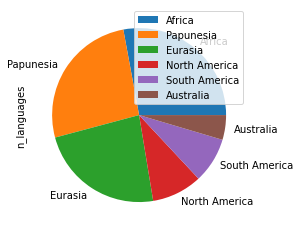

In [49]:
select_macroarea_nlanguages = sa.select(Macroarea.name.label('macroarea'),
                                        sa.func.count().label('n_languages'))\
                              .select_from(sa.outerjoin(Macroarea,
                                    sa.join(languoid_macroarea, Languoid)))\
                              .where(Languoid.level == LANGUAGE)\
                              .group_by(Macroarea.name)\
                              .order_by(sa.desc('n_languages'))

_ = read_sql(select_macroarea_nlanguages, index_col='macroarea')
_.plot.pie(y='n_languages')
_

In [50]:
macroareas = sa.func.group_concat(Macroarea.name, ', ').label('macroareas')

select_multiarea_languages = sa.select(Languoid.id, Languoid.name, macroareas)\
                             .select_from(sa.join(Languoid, languoid_macroarea).join(Macroarea))\
                             .where(Languoid.level == LANGUAGE)\
                             .group_by(Languoid.id)\
                             .having(sa.func.count() > 1)\
                             .order_by('id')
    
assert read_sql(select_multiarea_languages).empty

SELECT languoid.id, languoid.name, group_concat(macroarea.name, ?) AS macroareas 
FROM languoid JOIN languoid_macroarea ON languoid.id = languoid_macroarea.languoid_id JOIN macroarea ON macroarea.name = languoid_macroarea.macroarea_name 
WHERE languoid.level = ? GROUP BY languoid.id 
HAVING count(*) > ? ORDER BY languoid.id
[generated in 0.00055s] (', ', 'language', 1)


## country

In [51]:
from treedb.models import Country, languoid_country

print_sql(Country)
print_sql(languoid_country)

SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
[cached since 5.441s ago] ('table', 'country')
SELECT count(*) AS n_rows 
FROM country
[generated in 0.00049s] ()


CREATE TABLE country (
	id VARCHAR(2) NOT NULL CHECK (length(id) = 2), 
	name TEXT NOT NULL CHECK (name != ''), 
	PRIMARY KEY (id), 
	UNIQUE (name)
) WITHOUT ROWID
226


SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
[cached since 5.447s ago] ('table', 'languoid_country')
SELECT count(*) AS n_rows 
FROM languoid_country
[generated in 0.00054s] ()


CREATE TABLE languoid_country (
	languoid_id VARCHAR(8) NOT NULL, 
	country_id VARCHAR(2) NOT NULL, 
	PRIMARY KEY (languoid_id, country_id), 
	FOREIGN KEY(languoid_id) REFERENCES languoid (id), 
	FOREIGN KEY(country_id) REFERENCES country (id)
) WITHOUT ROWID
10992


In [52]:
select_country_nlanguages = sa.select(Country.name.label('country'),
                                      sa.func.count().label('n_languages'))\
                            .select_from(sa.outerjoin(Country,
                                                      sa.join(languoid_country, Languoid)))\
                            .where(Languoid.level == LANGUAGE)\
                            .group_by(Country.id)\
                            .order_by(sa.desc('n_languages'))\
                            .limit(10)

read_sql(select_country_nlanguages, index_col='country')

SELECT country.name AS country, count(*) AS n_languages 
FROM country LEFT OUTER JOIN (languoid_country JOIN languoid ON languoid.id = languoid_country.languoid_id) ON country.id = languoid_country.country_id 
WHERE languoid.level = ? GROUP BY country.id ORDER BY n_languages DESC
 LIMIT ? OFFSET ?
[generated in 0.00047s] ('language', 10, 0)


,n_languages
country,
Papua New Guinea,897
Indonesia,743
Nigeria,572
India,498
China,398
Australia,393
Mexico,328
Brazil,323
United States,321


In [53]:
select_lang_country = sa.select(Languoid.id, Languoid.name, Country.id.label('country'))\
                      .select_from(sa.join(Languoid, languoid_country).join(Country))\
                      .where(Languoid.level == LANGUAGE)\
                      .order_by(Languoid.id, 'country')\
                      .alias('lang_country')

countries = sa.func.group_concat(select_lang_country.c.country, ', ').label('countries')

select_multicountry_languages = sa.select(select_lang_country.c.id,
                                          select_lang_country.c.name,
                                          sa.func.count().label('n_countries'),
                                          countries)\
                                .group_by(select_lang_country.c.id,
                                          select_lang_country.c.name)\
                                .having(sa.func.count() > 1)\
                                .order_by(sa.desc('n_countries'),
                                          select_lang_country.c.id)\
                                .limit(10)
    
read_sql(select_multicountry_languages, index_col='id')

SELECT lang_country.id, lang_country.name, count(*) AS n_countries, group_concat(lang_country.country, ?) AS countries 
FROM (SELECT languoid.id AS id, languoid.name AS name, country.id AS country 
FROM languoid JOIN languoid_country ON languoid.id = languoid_country.languoid_id JOIN country ON country.id = languoid_country.country_id 
WHERE languoid.level = ? ORDER BY languoid.id, country) AS lang_country GROUP BY lang_country.id, lang_country.name 
HAVING count(*) > ? ORDER BY n_countries DESC, lang_country.id
 LIMIT ? OFFSET ?
[generated in 0.00043s] (', ', 'language', 1, 10, 0)


,name,n_countries,countries
id,,,
stan1288,Spanish,30,"AD, AR, BO, BR, BZ, CL, CO, CR, CU, DO, EC, ES..."
stan1293,English,26,"AU, BM, BR, BZ, CA, CK, CU, DO, FK, GB, GI, GP..."
stan1318,Standard Arabic,25,"AE, BH, DJ, DZ, EG, ER, IL, IQ, JO, KM, KW, LB..."
amer1248,American Sign Language,22,"BB, BF, BJ, BO, CA, CD, CF, CI, CN, GA, GH, JM..."
east2295,Eastern Yiddish,22,"AR, AU, BE, BY, CA, CR, EE, HU, IL, LT, LV, MD..."
russ1263,Russian,19,"BY, CN, EE, FI, GE, KG, KP, KZ, LT, LV, MD, MN..."
stan1295,German,16,"AT, BE, CH, CZ, DE, DK, FR, HU, IT, LI, LU, NL..."
port1283,Portuguese,15,"AD, AR, BO, BR, CO, ES, FR, GF, GY, PE, PT, PY..."
sint1235,Sinte Romani,13,"AT, CH, CZ, DE, FR, HR, IT, KZ, ME, NL, PL, RS..."


SELECT language_ncountries.n_countries, count(*) AS n_languages 
FROM (SELECT languoid.id AS id, count(*) AS n_countries 
FROM languoid LEFT OUTER JOIN languoid_country ON languoid.id = languoid_country.languoid_id 
WHERE languoid.level = ? GROUP BY languoid.id) AS language_ncountries GROUP BY language_ncountries.n_countries ORDER BY language_ncountries.n_countries
[generated in 0.00049s] ('language',)
SELECT ? AS value, count(*) AS count, sum(language_ncountries.n_countries) AS sum, min(language_ncountries.n_countries) AS min, max(language_ncountries.n_countries) AS max, avg(language_ncountries.n_countries) AS mean 
FROM (SELECT languoid.id AS id, count(*) AS n_countries 
FROM languoid LEFT OUTER JOIN languoid_country ON languoid.id = languoid_country.languoid_id 
WHERE languoid.level = ? GROUP BY languoid.id) AS language_ncountries
[generated in 0.00062s] ('n_countries', 'language')


,count,sum,min,max,mean
n_countries,8516,10935,1,30,1.284054


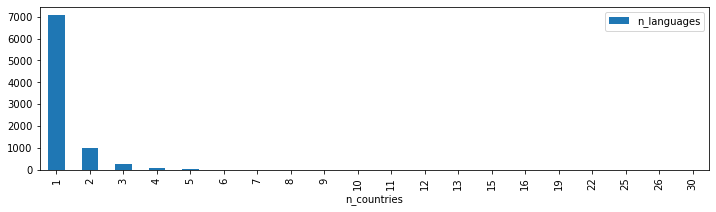

In [54]:
n_countries =  sa.select(Languoid.id, sa.func.count().label('n_countries'))\
               .select_from(sa.outerjoin(Languoid, languoid_country))\
               .where(Languoid.level == LANGUAGE)\
               .group_by(Languoid.id)\
               .alias('language_ncountries')\
               .c.n_countries

select_lc_dist = sa.select(n_countries, sa.func.count().label('n_languages'))\
                 .group_by(n_countries)\
                 .order_by('n_countries')

_ = read_sql(select_lc_dist, index_col='n_countries')

_.plot.bar(figsize=(12, 3))

read_sql(sa.select(sa.literal('n_countries').label('value'),
                   sa.func.count().label('count'),
                   sa.func.sum(n_countries).label('sum'),
                   sa.func.min(n_countries).label('min'),
                   sa.func.max(n_countries).label('max'),
                   sa.func.avg(n_countries).label('mean')),
         index_col='value').rename_axis(None)

## altname

SELECT altnameprovider.name AS altname_provider, count(DISTINCT altname.languoid_id) AS n_languoids 
FROM altnameprovider JOIN altname ON altnameprovider.id = altname.provider_id GROUP BY altnameprovider.name ORDER BY n_languoids, altname_provider
[generated in 0.00050s] ()


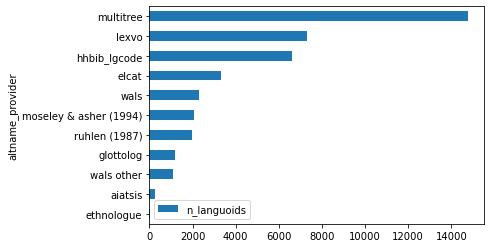

In [55]:
from treedb.models import Altname, AltnameProvider

select_provider_nlanguoids = sa.select(AltnameProvider.name.label('altname_provider'),
                                       sa.func.count(sa.distinct(Altname.languoid_id)).label('n_languoids'))\
                             .select_from(sa.join(AltnameProvider, Altname))\
                             .group_by(AltnameProvider.name)\
                             .order_by('n_languoids', 'altname_provider')

read_sql(select_provider_nlanguoids, index_col='altname_provider').plot.barh();

SELECT languoid_naltnames.n_altnames, count(*) AS n_languoids 
FROM (SELECT languoid.id AS id, count(*) AS n_altnames 
FROM languoid LEFT OUTER JOIN altname ON languoid.id = altname.languoid_id GROUP BY languoid.id) AS languoid_naltnames GROUP BY languoid_naltnames.n_altnames ORDER BY languoid_naltnames.n_altnames
[generated in 0.00041s] ()
SELECT ? AS value, count(*) AS count, sum(languoid_naltnames.n_altnames) AS sum, min(languoid_naltnames.n_altnames) AS min, max(languoid_naltnames.n_altnames) AS max, avg(languoid_naltnames.n_altnames) AS mean 
FROM (SELECT languoid.id AS id, count(*) AS n_altnames 
FROM languoid LEFT OUTER JOIN altname ON languoid.id = altname.languoid_id GROUP BY languoid.id) AS languoid_naltnames
[generated in 0.00062s] ('n_altnames',)


,count,sum,min,max,mean
n_altnames,25439,159700,1,251,6.277762


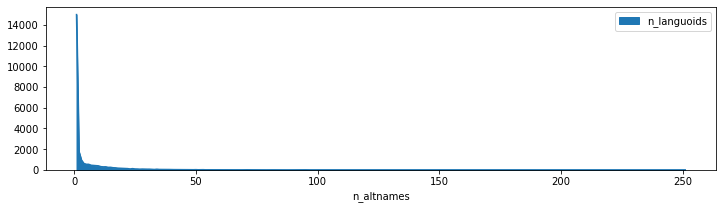

In [56]:
n_altnames = sa.select(Languoid.id, sa.func.count().label('n_altnames'))\
             .select_from(sa.outerjoin(Languoid, Altname))\
             .group_by(Languoid.id)\
             .alias('languoid_naltnames')\
             .c.n_altnames

select_la_dist = sa.select(n_altnames, sa.func.count().label('n_languoids'))\
                 .group_by(n_altnames)\
                 .order_by(n_altnames)

_ = read_sql(select_la_dist, index_col='n_altnames')

_.plot.area(figsize=(12, 3))

read_sql(sa.select(sa.literal('n_altnames').label('value'),
                   sa.func.count().label('count'),
                   sa.func.sum(n_altnames).label('sum'),
                   sa.func.min(n_altnames).label('min'),
                   sa.func.max(n_altnames).label('max'),
                   sa.func.avg(n_altnames).label('mean')),
         index_col='value').rename_axis(None)

## source

In [57]:
from treedb.models import Source, SourceProvider

select_provider_nsources = sa.select(SourceProvider.name.label('provider'),
                                     Languoid.level,
                                     sa.func.count().label('n_sources'))\
                           .select_from(sa.join(SourceProvider, Source).join(Languoid))\
                           .group_by(SourceProvider.name, Languoid.level)\
                           .order_by('provider', sa.desc('n_sources'))

read_sql(select_provider_nsources, index_col=['provider', 'level'])

SELECT sourceprovider.name AS provider, languoid.level, count(*) AS n_sources 
FROM sourceprovider JOIN source ON sourceprovider.id = source.provider_id JOIN languoid ON languoid.id = source.languoid_id GROUP BY sourceprovider.name, languoid.level ORDER BY provider, n_sources DESC
[generated in 0.00053s] ()


n_sources
provider  level              
glottolog language     185740
          family         2385
          dialect        1649

SELECT lang_nsources.n_sources, count(*) AS n_languoids 
FROM (SELECT languoid.id AS id, count(source.languoid_id) AS n_sources 
FROM languoid LEFT OUTER JOIN source ON languoid.id = source.languoid_id GROUP BY languoid.id) AS lang_nsources GROUP BY lang_nsources.n_sources ORDER BY n_languoids
[generated in 0.00050s] ()
SELECT ? AS value, count(*) AS count, sum(lang_nsources.n_sources) AS sum, min(lang_nsources.n_sources) AS min, max(lang_nsources.n_sources) AS max, avg(lang_nsources.n_sources) AS mean 
FROM (SELECT languoid.id AS id, count(source.languoid_id) AS n_sources 
FROM languoid LEFT OUTER JOIN source ON languoid.id = source.languoid_id GROUP BY languoid.id) AS lang_nsources
[generated in 0.00064s] ('n_sources',)


,count,sum,min,max,mean
n_sources,25439,189774,0,1547,7.459963


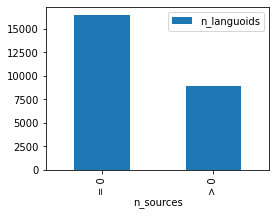

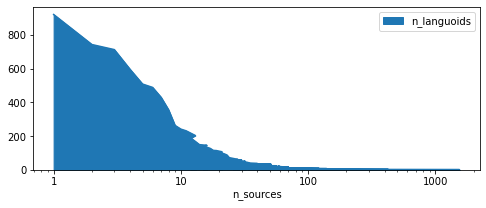

In [58]:
n_sources = sa.select(Languoid.id,
                      sa.func.count(Source.languoid_id).label('n_sources'))\
            .select_from(sa.outerjoin(Languoid, Source))\
            .group_by(Languoid.id)\
            .alias('lang_nsources')\
            .c.n_sources

select_nsources_nlangs = sa.select(n_sources, sa.func.count().label('n_languoids'))\
                         .group_by(n_sources)\
                         .order_by('n_languoids')

_ = read_sql(select_nsources_nlangs, index_col='n_sources')
_.groupby(_.index != 0).sum().rename_axis('n_sources')\
    .rename(index={False: '= 0', True: '> 0'}).plot.bar(figsize=(4, 3))
_.drop(0).plot.area(figsize=(8, 3), logx=True)\
    .xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())

read_sql(sa.select(sa.literal('n_sources').label('value'),
                   sa.func.count().label('count'),
                   sa.func.sum(n_sources).label('sum'),
                   sa.func.min(n_sources).label('min'),
                   sa.func.max(n_sources).label('max'),
                   sa.func.avg(n_sources).label('mean')),
         index_col='value').rename_axis(None)

SELECT lang_nsources.level, lang_nsources.n_sources, count(*) AS n_languoids 
FROM (SELECT languoid.id AS id, languoid.level AS level, count(source.languoid_id) AS n_sources 
FROM languoid LEFT OUTER JOIN source ON languoid.id = source.languoid_id GROUP BY languoid.id, languoid.level) AS lang_nsources GROUP BY lang_nsources.level, lang_nsources.n_sources ORDER BY n_languoids
[generated in 0.00050s] ()


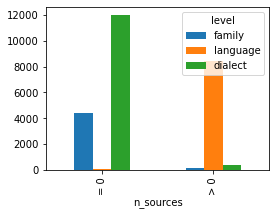

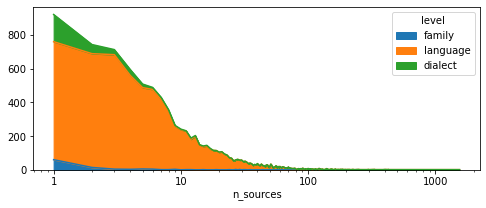

In [59]:
select_lang_nsources = sa.select(Languoid.id, Languoid.level,
                                 sa.func.count(Source.languoid_id).label('n_sources'))\
                       .select_from(sa.outerjoin(Languoid, Source))\
                       .group_by(Languoid.id, Languoid.level)\
                       .alias('lang_nsources')

select_ln_nlangs = sa.select(select_lang_nsources.c.level,
                             select_lang_nsources.c.n_sources,
                             sa.func.count().label('n_languoids'))\
                   .group_by(select_lang_nsources.c.level, select_lang_nsources.c.n_sources)\
                   .order_by('n_languoids')

_ = read_sql(select_ln_nlangs).pivot(index='n_sources', columns='level', values='n_languoids')
_.groupby(_.index != 0).sum()[list(treedb.LEVEL)].rename_axis('n_sources')\
    .rename(index={False: '= 0', True: '> 0'}).plot.bar(figsize=(4, 3))
_.drop(0)[list(treedb.LEVEL)].plot.area(figsize=(8, 3), logx=True)\
    .xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())

SELECT bibfile.name AS bibfile, count(*) AS n_used 
FROM bibfile JOIN bibitem ON bibfile.id = bibitem.bibfile_id GROUP BY bibfile.name ORDER BY n_used DESC
[generated in 0.00056s] ()


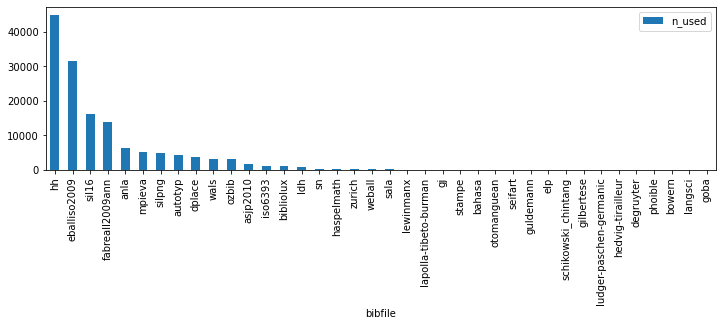

In [60]:
from treedb.models import Bibfile, Bibitem

select_bibfile_nused = sa.select(Bibfile.name.label('bibfile'), sa.func.count().label('n_used'))\
                       .select_from(sa.join(Bibfile, Bibitem))\
                       .group_by(Bibfile.name)\
                       .order_by(sa.desc('n_used'))

read_sql(select_bibfile_nused, index_col='bibfile').plot.bar(figsize=(12, 3));

## classification

In [61]:
from treedb.models import ClassificationRef

select_cr_levels = sa.select(ClassificationRef.kind, Languoid.level,
                             sa.func.count().label('n_classificationrefs'))\
                   .select_from(sa.join(ClassificationRef, Languoid))\
                   .group_by(ClassificationRef.kind, Languoid.level)\
                   .order_by('kind', 'level')

read_sql(select_cr_levels, index_col=['kind', 'level']).unstack()

SELECT classificationref.kind, languoid.level, count(*) AS n_classificationrefs 
FROM classificationref JOIN languoid ON languoid.id = classificationref.languoid_id GROUP BY classificationref.kind, languoid.level ORDER BY classificationref.kind, languoid.level
[generated in 0.00063s] ()


n_classificationrefs                
level               dialect family language
kind                                       
family                    8    442      256
sub                      77   5867     9800

SELECT lang_ncrefs.n_crefs, count(*) AS n_languoids 
FROM (SELECT languoid.id AS id, count(*) AS n_crefs 
FROM languoid LEFT OUTER JOIN classificationref ON languoid.id = classificationref.languoid_id GROUP BY languoid.id) AS lang_ncrefs GROUP BY lang_ncrefs.n_crefs ORDER BY lang_ncrefs.n_crefs
[generated in 0.00053s] ()
SELECT ? AS value, count(*) AS count, sum(lang_ncrefs.n_crefs) AS sum, min(lang_ncrefs.n_crefs) AS min, max(lang_ncrefs.n_crefs) AS max, avg(lang_ncrefs.n_crefs) AS mean 
FROM (SELECT languoid.id AS id, count(*) AS n_crefs 
FROM languoid LEFT OUTER JOIN classificationref ON languoid.id = classificationref.languoid_id GROUP BY languoid.id) AS lang_ncrefs
[generated in 0.00071s] ('n_crefs',)


,count,sum,min,max,mean
n_crefs,25439,29983,1,11,1.178623


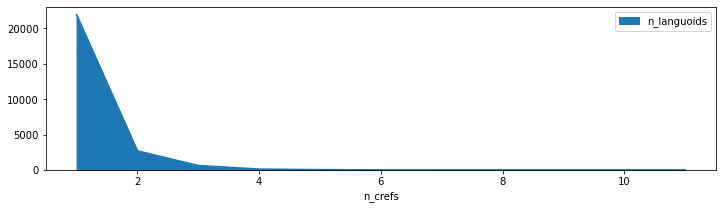

In [62]:
n_crefs = sa.select(Languoid.id, sa.func.count().label('n_crefs'))\
          .select_from(sa.outerjoin(Languoid, ClassificationRef))\
          .group_by(Languoid.id)\
          .alias('lang_ncrefs')\
          .c.n_crefs

select_lcr_dist = sa.select(n_crefs, sa.func.count().label('n_languoids'))\
                  .group_by(n_crefs)\
                  .order_by(n_crefs)

_ = read_sql(select_lcr_dist, index_col='n_crefs')

_.plot.area(figsize=(12, 3))

read_sql(sa.select(sa.literal('n_crefs').label('value'),
                   sa.func.count().label('count'),
                   sa.func.sum(n_crefs).label('sum'),
                   sa.func.min(n_crefs).label('min'),
                   sa.func.max(n_crefs).label('max'),
                   sa.func.avg(n_crefs).label('mean')),
        index_col='value').rename_axis(None)

## link

In [63]:
from treedb.models import Link

print_sql(Link)

SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
[cached since 7.59s ago] ('table', 'link')
SELECT count(*) AS n_rows 
FROM link
[generated in 0.00053s] ()


CREATE TABLE link (
	languoid_id VARCHAR(8) NOT NULL, 
	ord INTEGER NOT NULL CHECK (ord >= 1), 
	url TEXT NOT NULL CHECK (url != ''), 
	title TEXT CHECK (title != ''), 
	scheme TEXT, 
	PRIMARY KEY (languoid_id, ord), 
	UNIQUE (languoid_id, url), 
	CHECK (substr(url, 1, length(scheme) + 3) = scheme || '://'), 
	FOREIGN KEY(languoid_id) REFERENCES languoid (id), 
	CHECK (scheme IN ('http', 'https'))
) WITHOUT ROWID
29297


SELECT link.scheme AS link_scheme, count(*) AS n_links 
FROM link GROUP BY link.scheme ORDER BY n_links DESC
[generated in 0.00043s] ()


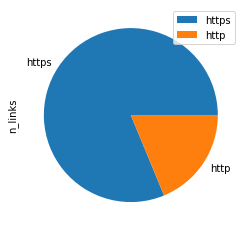

In [64]:
select_scheme_nlinks = sa.select(Link.scheme.label('link_scheme'), sa.func.count().label('n_links'))\
                       .group_by(Link.scheme)\
                       .order_by(sa.desc('n_links'))

read_sql(select_scheme_nlinks, index_col='link_scheme').plot.pie(y='n_links');

SELECT link.url 
FROM link
[generated in 0.00046s] ()


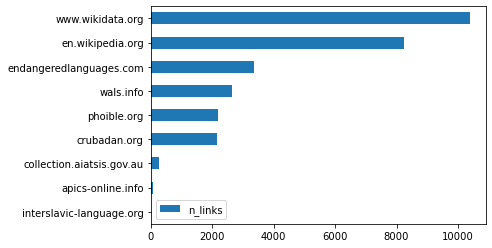

In [65]:
from urllib.parse import urlparse

hosts = collections.Counter(urlparse(url).hostname for url, in treedb.iterrows(sa.select([Link.url])))

pd.DataFrame.from_dict(hosts, orient='index', columns=['n_links'])\
    .sort_values(by='n_links').plot.barh();

## endangerment

In [66]:
from treedb.models import Endangerment, EndangermentSource

print_sql(Endangerment)
print_sql(EndangermentSource)

SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
[cached since 7.998s ago] ('table', 'endangerment')
SELECT count(*) AS n_rows 
FROM endangerment
[generated in 0.00045s] ()


CREATE TABLE endangerment (
	languoid_id VARCHAR(8) NOT NULL, 
	status VARCHAR(14) NOT NULL, 
	source_id INTEGER NOT NULL, 
	date DATETIME NOT NULL, 
	comment TEXT NOT NULL CHECK (comment != ''), 
	PRIMARY KEY (languoid_id), 
	FOREIGN KEY(languoid_id) REFERENCES languoid (id), 
	CHECK (status IN ('not endangered', 'threatened', 'shifting', 'moribund', 'nearly extinct', 'extinct')), 
	FOREIGN KEY(source_id) REFERENCES endangerment_source (id)
) WITHOUT ROWID
8215


SELECT sqlite_master.sql 
FROM sqlite_master 
WHERE sqlite_master.type = ? AND sqlite_master.name = ?
[cached since 8.006s ago] ('table', 'endangerment_source')
SELECT count(*) AS n_rows 
FROM endangerment_source
[generated in 0.00043s] ()


CREATE TABLE endangerment_source (
	id INTEGER NOT NULL, 
	name TEXT NOT NULL CHECK (name != ''), 
	bibitem_id INTEGER, 
	pages TEXT CHECK (pages != ''), 
	PRIMARY KEY (id), 
	UNIQUE (bibitem_id, pages), 
	CHECK ((bibitem_id IS NULL) = (pages IS NULL)), 
	UNIQUE (name), 
	FOREIGN KEY(bibitem_id) REFERENCES bibitem (id)
)
36


SELECT endangerment_source.name AS source, count(*) AS n_endangerments 
FROM endangerment JOIN endangerment_source ON endangerment_source.id = endangerment.source_id GROUP BY endangerment_source.name ORDER BY n_endangerments
[generated in 0.00047s] ()


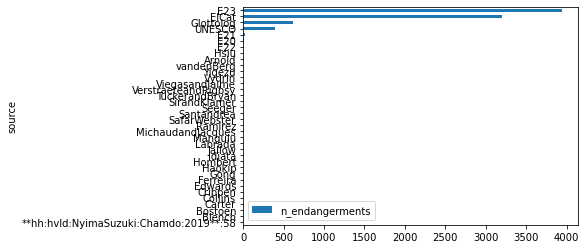

In [67]:
e_source = EndangermentSource.name.label('source')

select_source_nendangerments = sa.select(e_source, sa.func.count().label('n_endangerments'))\
                               .select_from(sa.join(Endangerment, EndangermentSource))\
                               .group_by(e_source)\
                               .order_by('n_endangerments')

read_sql(select_source_nendangerments, index_col='source').plot.barh();

## denormalized

In [68]:
%time treedb.hash_csv(treedb.get_query())

WITH RECURSIVE tree(child_id, parent_id, steps, terminal) AS 
(SELECT child.id AS child_id, child.id AS parent_id, ? AS steps, child.parent_id IS NULL AS terminal 
FROM languoid AS child UNION ALL SELECT tree.child_id AS child_id, parent.parent_id AS parent_id, tree.steps + ? AS steps, grandparent.parent_id IS NULL AS terminal 
FROM tree JOIN languoid AS parent ON tree.parent_id = parent.id AND parent.parent_id IS NOT NULL LEFT OUTER JOIN languoid AS grandparent ON parent.parent_id = grandparent.id)
 SELECT languoid.id, languoid.name, languoid.level, languoid.parent_id, (SELECT group_concat(parent_path.path_part, ?) AS path 
FROM (SELECT tree.parent_id AS path_part 
FROM tree 
WHERE tree.child_id = languoid.id ORDER BY tree.steps DESC) AS parent_path) AS path, (SELECT tree.parent_id 
FROM tree 
WHERE tree.child_id = languoid.id AND tree.steps > ? AND tree.terminal = 1) AS family_id, (SELECT tree.parent_id 
FROM tree 
WHERE tree.child_id = languoid.id AND languoid.level = ? AND (EXISTS 

[generated in 0.00093s] (0, 1, '/', 0, 'dialect', 'language', ', ', ', ', ', ', '[%s](%s)', ', ', '**%s:%s**:%s<trigger "%s">', '**%s:%s**:%s', '**%s:%s**<trigger "%s">', '**%s:%s**', 'glottolog', ', ', '', '%s [%s]', 'aiatsis', ', ', '', '%s [%s]', 'elcat', ', ', '', '%s [%s]', 'ethnologue', ', ', '', '%s [%s]', 'glottolog', ', ', '', '%s [%s]', 'hhbib_lgcode', ', ', '', '%s [%s]', 'lexvo', ', ', '', '%s [%s]', 'moseley & asher (1994)', ', ', '', '%s [%s]', 'multitree', ', ', '', '%s [%s]', 'ruhlen (1987)', ', ', '', '%s [%s]', 'wals', ', ', '', '%s [%s]', 'wals other', ', ', 'lgcode', ', ', 'inlg', ', ', '**%s:%s**:%s', '**%s:%s**', 'sub', ', ', '**%s:%s**:%s', '**%s:%s**', 'family', '**%s:%s**:%s', ', ', 'endangeredlanguages', 'languagelandscape', 'multitree', 'wals', 'sub', 'family')
[INFO@treedb.queries] hash rows with 'sha256', csv header: ['id', 'name', 'level', 'parent_id', 'path', 'family_id', 'dialect_language_id', 'hid', 'iso639_3', 'latitude', 'longitude', 'macroareas', 'co

Wall time: 4.12 s


'bf8af9e4840642f4622cec41bf3156afac75317740ff0eef1ac75ec1998d4f78'